In [1]:
%matplotlib widget

import tomopy
from alignment import *
from tomo_processing import *

import numpy as np
import matplotlib.pyplot as plt

import sscCdi

In [2]:
shifts = np.load('pixel_shifts.npy')
angles = np.load('angles.npy')
donut = np.load('regular_angles_donut_shifted.npy')
donut.shape,shifts.shape,angles.shape

((361, 256, 256), (361, 2), (361, 2))

In [13]:
donut = donut/np.max(donut)

In [14]:
# sscCdi.deploy_visualizer(donut,title='Sinogram',cmap='gray')

In [15]:
aligned_data_CC = alignment_variance_field(donut, downscaling_factor=0,fft_upsampling=10,return_common_valid_region=True, remove_null_borders = True, use_gradient = True)

Finding shift between neighboor slices...
Finding shift between slices #0/361
Finding shift between slices #50/361
Finding shift between slices #100/361
Finding shift between slices #150/361
Finding shift between slices #200/361
Finding shift between slices #250/361
Finding shift between slices #300/361
Finding shift between slices #350/361
Shifting slice #0/361
Shifting slice #50/361
Shifting slice #100/361
Shifting slice #150/361
Shifting slice #200/361
Shifting slice #250/361
Shifting slice #300/361
Shifting slice #350/361


In [16]:
# sscCdi.deploy_visualizer(aligned_data_CC,title='Sinogram',cmap='gray')

Calculating 1D mass distribution...
Finding shift between neighboor slices...
Shifting slices...
Aligning volume...
Aligning slice #0/361
Aligning slice #50/361
Aligning slice #100/361
Aligning slice #150/361
Aligning slice #200/361
Aligning slice #250/361
Aligning slice #300/361
Aligning slice #350/361


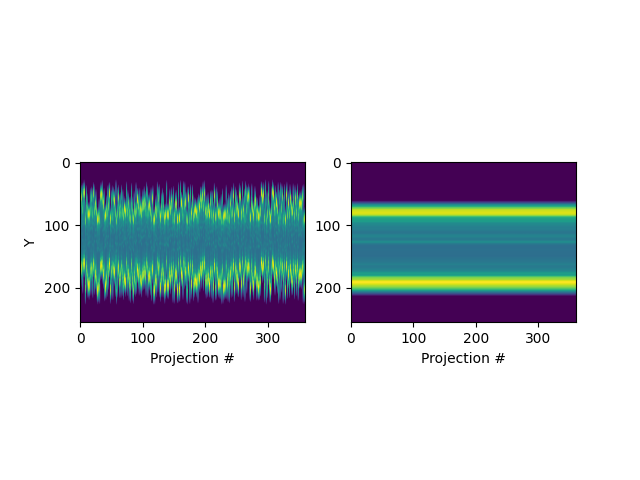

In [17]:
aligned_data_VMF, curves, total_shift = alignment_vertical_mass_fluctuation(donut, filter_sigma = 0, curve_portion = None, use_phase_gradient = False, return_common_valid_region=True, remove_null_borders = True, plot = 0) # if data is not equalized, phase gradient should be used

In [18]:
# sscCdi.deploy_visualizer(aligned_data_VMF,title='Sinogram',cmap='gray')

Calculating 1D mass distribution...
Calculating 1D mass distribution...


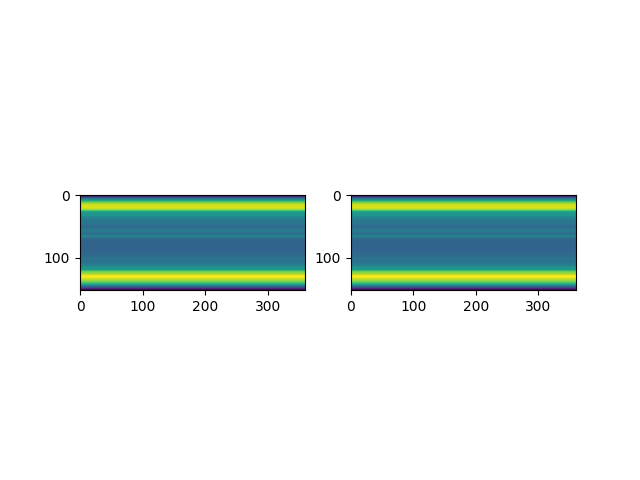

In [23]:
curves0 = get_VMF_curves(aligned_data_VMF,use_phase_gradient=False,filter_sigma=0,curve_portion=None)
curves = get_VMF_curves(aligned_data_CC,use_phase_gradient=False,filter_sigma=0,curve_portion=None)

fig, ax = plt.subplots(1,2)
ax[0].imshow(curves0.T)
ax[1].imshow(curves.T)

In [20]:
dic = {}
dic['using_wiggle'] = False
dic["project_angles_to_regular_grid"] = False

dic['automatic_regularization'] = 0 # skip if 0; regularization between 0 and 1 to enhance borders prior to recon (https://www.sciencedirect.com/science/article/pii/S2590037419300883?via%3Dihub)

# dic["algorithm_dic"] = { # if FBP: filtered back-projection
#     'algorithm': "FBP",
#     'gpu': [0],
#     'filter': 'lorentz', # 'gaussian','lorentz','cosine','rectangle'
#     'regularization': 0.1, # 0 <= regularization <= 1; use for smoothening
#     'shift center':0,
# }

dic["algorithm_dic"] = { # if eEM: emission expectation maximization
    'algorithm': "EM",
    'gpu': [0],
    'regularization': 0.1,
    'method': 'eEM', 
    'niterations': [20,0,0,0], # [global iterations, iterations EMTV, iterations2 EMTV, Cone-beam integration points]
    'epsilon': 1e-15, #for EMTV only
    'blocksize': 20, # blocks for parallelization
}

dic["ordered_angles_filepath"] = '/ibira/lnls/labs/tepui/home/yuri.tonin/ssc-cdi/sscCdi/processing/dev/alignment/angles.npy'
recon3D_CC = tomo_recon(dic,aligned_data_CC,save=False)
recon3D_VMF = tomo_recon(dic,aligned_data_VMF,save=False)

Starting tomographic algorithm EM algorithm
	 Tomography done!
Time elapsed: Tomography: 0.27090930938720703 s
Starting tomographic algorithm EM algorithm
	 Tomography done!
Time elapsed: Tomography: 0.3451576232910156 s


In [29]:
recon3D_CC[recon3D_CC>30]=0

In [27]:
sscCdi.deploy_visualizer(recon3D_CC,title='Sinogram',cmap='gray',axis=1)

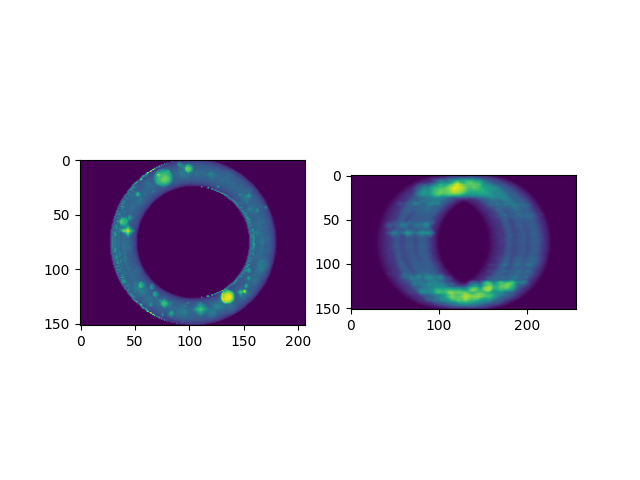

In [30]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(np.sum(recon3D_CC,axis=1))
ax[1].imshow(np.sum(recon3D_VMF,axis=1))